# Introduction
The Data Analytics API allows you to retrieve historical order and trade events far beyond what is available in Joule or the Joule Direct API. This notebook demonstrates the basic functionality of the API and some of the common workflows used by Trayport's clients.

## Documentation


*   [API documentation](https://downloads.trayport.com//downloads/Documentation/DataAnalytics/Data_Analytics_API.pdf)
*   [Data Analytics Swagger](https://www.trayport.com/en/support/daapi/index.html)
* [Reference Data Swagger](https://www.trayport.com/en/support/refdataapi/index.html)

## Imports & Preparation
This section imports the various Python libraries used to run the rest of the notebook, defines the API endpoints and creates some helper functions.

In [ ]:
from IPython.display import display, Markdown, HTML

import pandas as pd
import numpy as np
import requests
import json

from datetime import date, datetime, timedelta
from calendar import WEDNESDAY, THURSDAY
from time import time
import getpass
from functools import partial

import plotly
import plotly.graph_objs as go
from plotly.offline import plot, iplot

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%f' % x)

In [ ]:
refdata_base_url = 'https://referencedata.trayport.com'
analytics_base_url = 'https://analytics.trayport.com/api'

instruments_url = refdata_base_url + '/instruments'
markets_url = refdata_base_url + '/markets'
sequences_url = refdata_base_url + '/sequences'

trades_url = analytics_base_url + '/trades'
ohlcv_url = analytics_base_url + '/trades/ohlcv'
last_url = analytics_base_url + '/trades/last'
private_url = analytics_base_url + '/trades/private'
activity_url = analytics_base_url + '/trades/activity'
book_url = analytics_base_url + '/orders/book'
book_top_url = analytics_base_url + '/orders/book/top'

In [ ]:
#Create some time variables for last Wednesday (likely to be a trading day!)
#These will be used in future queries throughout the notebook

today = date.today()
MON, TUE, WED, THU, FRI, SAT, SUN = range(7)

def lastWeekday(weekday):
  #Mon = 0, Tue = 1, Sun = 6
  offset = (date.today().weekday() + 6 - weekday) % 7 + 1
  return date.today() - timedelta(days=offset)

last_wednesday = lastWeekday(WED)
last_wednesday_open = last_wednesday.strftime("%Y-%m-%dT07:00:00Z")
last_wednesday_close = last_wednesday.strftime("%Y-%m-%dT16:00:00Z")

## Authorization
Requests made to the Analytics and Reference Data APIs are authorized by providing an API key in the `X-API-KEY` header on all requests.

Entering your API key below will cause it to be used to authorize all requests made from this notebook. Note that if you are pasting the key you may need to use the 'Ctrl + Shift + V' shortcut to allow it to be entered as plain text.

In [ ]:

api_key = getpass.getpass("Please enter your Analytics API key and then press ENTER. Note that you may need to use 'Ctrl + Shift + V' when pasting:\n")
headers = {
    'x-api-key': api_key
}

def get(url, params, headers):
  start_time = time()
  r = requests.get(url, params, headers=headers)
  duration = time() - start_time
  print(r.request.url)
  print(f'Duration: {duration:.3f}s')
  if r.status_code != 200:
    raise Exception(f'Status: {r.status_code}. {r.content.decode("utf-8")}')
  return r.content.decode("utf-8")

def get_obj(url, params={}, headers=headers):
  content = get(url, params, headers)
  return json.loads(content)

def get_df(url, params={}, headers=headers):
  content = get(url, params, headers)
  df = pd.read_json(content, convert_dates=['timestamp','fromTimestamp', 'toTimestamp'])
  if len(df) > 0:
    if 'timestamp' in df.columns:
      df.set_index('timestamp', inplace=True)
  return df

# Using the Reference Data API
Order and trade queries in the Analytics API are specified against a specific contract or commingled market. For example, you might look for trades for NBP Apr-22.

Contracts are specified by sending the IDs for the instruments (e.g. `10000625` for `NBP ICE`), the sequence (e.g. `10000305` for `Months`) and the item (e.g. `220` for `Apr-22`).

You can use the Reference Data API to find the IDs for the contracts you wish to query with the Analytics API. The examples below show some common workflows.


## Finding the instrument
Suppose that you want to issue a query for TTF DA trades. You'll need to start by finding the instrument ID. If you don't already know it, you can download a list of all available instruments using the `/instruments` endpoint:

In [ ]:
instruments = get_df(instruments_url)
instruments

This shows the name and ID of each instrument in Trayport's collection. These will match the names and IDs available in Joule and in the Joule Direct API.

If you know the name of the instrument you're interested in, you can then find it in the list. For example, if you only want trades for the TTF OTC instrument, you can search the list for it by name. Details of the units and currencies for the instrument will be returned, along with a link that can be used to retrieve the sequences assigned to the instrument.

In [ ]:
ttf_otc_instrument = instruments[instruments['name'] == 'TTF Hi Cal 51.6'].to_dict('records')[0]
ttf_otc_details = get_df(instruments_url + '/' + str(ttf_otc_instrument['id']))
ttf_otc_instrument
ttf_otc_details

### Using Commingled Markets
Suppose you want data for multiple TTF instruments (eg. TTF EEX, TTF ICE, etc). You _could_ search the list for all TTF instruments by name:

In [ ]:
ttf_instruments = instruments[instruments['name'].apply(lambda n: 'TTF' in n)]
ttf_instruments

However, the obvious problem with this is knowing which of these instruments can be safely grouped together - you probably don't want to include prices for the TTF USD instrument with the Euro-priced products, for example!

The Reference Data API solves this problem by allowing you to query the 'Commingled' (aka 'All Venues') markets that you can see in Joule. For example, you may wish to use the 'TTF Hi Cal 51.6*' commingled column from Joule, which contains 18 comparable instruments:

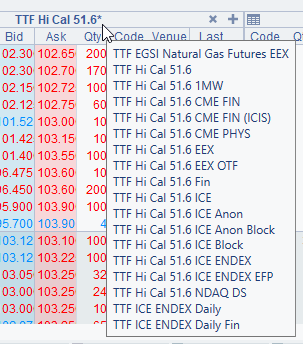

The `/markets` endpoint returns a list of all the commingled products available in Joule. You can then search this in the same way you would an instrument list:

In [ ]:
markets = get_df(markets_url)
display(markets)
ttf_market = markets[markets['name'] == 'TTF Hi Cal 51.6'].to_dict('records')[0]
display(ttf_market)

## Finding the delivery period
Delivery periods are grouped into 'Sequences' of similar items. For example, there are sequences for Gas Months, a sequence for Power Quarters, for Coal Years, etc.

You can use the Reference Data API to retrieve a list of sequences available for individual instruments or markets:

In [ ]:
ttf_market_sequences = get_df(refdata_base_url + ttf_market['sequences'])
display(ttf_market_sequences)

Once you've selected the sequence you are interested in, you can query the various delivery periods ('items') within that sequence. For example, the code below downloads all items from the Gas Prompt sequence:

In [ ]:
ttf_prompt_sequence = ttf_market_sequences[ttf_market_sequences['name'] == 'Gas - NG Prompt'].to_dict('records')[0];
ttf_prompt_sequence_items = get_df(refdata_base_url + ttf_market_sequences[ttf_market_sequences['name'] == 'Gas - NG Prompt'].to_dict('records')[0]['sequenceItems'])
da_item = ttf_prompt_sequence_items[ttf_prompt_sequence_items['name'] == 'DA'].to_dict('records')[0];
display(ttf_prompt_sequence_items)

The example above shows the `Gas - NG Prompt` items, which never expire.
However, most delivery periods do have defined start and end times, which are shown in the API - for example, on the `Gas - NG Months` sequence:

In [ ]:
ttf_months_sequence = ttf_market_sequences[ttf_market_sequences['name'] == 'Gas - NG Months'].to_dict('records')[0];
ttf_months_sequence = get_df(refdata_base_url + ttf_market_sequences[ttf_market_sequences['name'] == 'Gas - NG Months'].to_dict('records')[0]['sequenceItems'])
display(ttf_months_sequence)

### Expired delivery periods
Note that in the example above, the results for the `Gas - NG Months` sequence starts with the current delivery month. To retrieve expired delivery periods, you will need to set the optional 'StartDate' parameter on the Reference Data API query to some time in the past; it will then return items starting from that date. You can also use the optional `Count` parameter to control how many items are returned:

In [ ]:
params = {
    'StartDate': '2010-01-01T00:00:00Z',
    'Count': '10'
}
ttf_months_sequence = get_df(refdata_base_url + ttf_market_sequences[ttf_market_sequences['name'] == 'Gas - NG Months'].to_dict('records')[0]['sequenceItems'], params)
display(ttf_months_sequence)

# Trade Queries
Once you have the IDs for the market or instrument you're interested in, you can start retrieving trade information. There are five main endpoints available:

* `/trades` - Returns a list of trades that occurred within the given time range.
* `/trades/ohlcv` - Returns the Open, High, Low, Close and Volume for each time interval.
* `/trades/last` - Returns the price and time of the last trade for the given contract.
* `/trades/activity` - returns contracts that have been traded in the given time period and the number of trades for each.
* `/trades/private` - returns trades made by your company within the given time range.



## Simple Trades
You can retrieve up to 32 days' trades for a given contract with a single query. Basic information about each trade is returned, including its ID and execution venue.

NB: Only 32 days of trades can be queried at once; however, you can request trades back to the start of your relationship with Trayport (or before, depending on the venue - see [Chapter 2 of the API guide](https://downloads.trayport.com//downloads/Documentation/DataAnalytics/Data_Analytics_API.pdf) for more details).

Additional fields can be added to the output if requested in the `optionalFields` parameter. In the example below, the 'FromBrokenSpread' parameter is requested, which indicates whether the trade was the result of a spread being broken:

In [ ]:
params = {
    'from': last_wednesday_open,
    'until': last_wednesday_close,
     'marketId': ttf_market['id'],
     'sequenceId': ttf_prompt_sequence['id'],
    'sequenceItemId': da_item['id'],
    #'instrumentId': 10002096,
    #'sequenceId': 10000305,
    #'sequenceItemId': 228,
    'ContractType': 'SinglePeriod',
    # 'routes': ['all'],
    'optionalFields': ['FromBrokenSpread'],
}

df_ttf_da_trades = get_df(trades_url, params)
print(f'{len(df_ttf_da_trades)} rows')
df_ttf_da_trades

##Private Trades
By default, only the public (anonymous) versions of trades are returned by the Simple trades query. However, you can set the `includePrivate` parameter to `true` to include these.

In [ ]:
params = {
    'from': last_wednesday_open,
    'until': last_wednesday_close,
    'marketId': ttf_market['id'],
    'sequenceId': ttf_prompt_sequence['id'],
    'sequenceItemId': da_item['id'],
    'ContractType': 'SinglePeriod',
    'includePrivate': 'true'
}

df_ttf_da_trades = get_df(trades_url, params)
print(f'{len(df_ttf_da_trades)} rows')
df_ttf_da_trades

To retrieve *only* private trades, you can use the private trades endpoint, which doesn't require a contract to be specified (though you can use the contract fields

In [ ]:
params = {
    'from': last_wednesday_open,
    'until': last_wednesday_close,
    # 'marketId': ttf_market['id'],
    # 'sequenceId': ttf_prompt_sequence['id'],
    # 'sequenceItemId': da_item['id'],
    # 'ContractType': 'SinglePeriod'
}

private_df_ttf_da_trades = get_df(private_url, params)
print(f'{len(private_df_ttf_da_trades)} rows')
private_df_ttf_da_trades

## Period Spreads
The examples above show a query for a single delivery period. It is also possible to retrieve trade data for _spreads_ of delivery periods ('buying a spread' is buying the first leg and selling the second). To do this, you will need to provide the `secondSequenceItemId` parameter, which will be another delivery period from the same sequence. For example you might look for trades on front month vs next month on TTF:

In [ ]:
params = {
    'Count': '3'
}
ttf_months_sequence = get_df(refdata_base_url + ttf_market_sequences[ttf_market_sequences['name'] == 'Gas - NG Months'].to_dict('records')[0]['sequenceItems'], params)
front_month = ttf_months_sequence.to_dict('records')[1];
next_month = ttf_months_sequence.to_dict('records')[2];

display(front_month);
display(next_month);

params = {
    'from': last_wednesday_open,
    'until': last_wednesday_close,
    'marketId': ttf_market['id'],
    'sequenceId': ttf_market_sequences[ttf_market_sequences['name'] == 'Gas - NG Months']['id'],
    'sequenceItemId': front_month['id'],
    'secondSequenceItemId': next_month['id'],
    'ContractType': 'Spread'
}

df_ttf_spread_trades = get_df(trades_url, params)
print(f'{len(df_ttf_spread_trades)} rows')
df_ttf_spread_trades


## OHLCV
To retrieve OHLCV ('candlestick') data for a contract, you must provide a time range and the period of each bucket/candlestick. Periods can be defined as multiples of the following units:

* Minute
* Hour
* Day
* Month

The query below retrieves data for the Day Ahead TTF All Venues contract at 1m buckets from a day from the previous week. The data is then plotted as figure and candlestick charts.



In [ ]:
params = {
    'from': '2023-09',
    # 'from': last_wednesday_open,
    'until': last_wednesday_close,
    'interval': '15',
    'intervalUnit': 'minute',
    'marketId': ttf_market['id'],
    'sequenceId': ttf_prompt_sequence['id'],
    'sequenceItemId': da_item['id'],
    'ContractType': 'SinglePeriod',
    'optionalFields': ['vwap',
                       #'OpenTimestamp','CloseTimestamp'
                       ],
    'includeEmptyBuckets': 'true'
}

df_ttf_da_candle = get_df(ohlcv_url, params)
print(f'{len(df_ttf_da_candle)} rows')
df_ttf_da_candle

In [ ]:
data = [
    go.Candlestick(
        name = 'TTF Hi Cal 51.6*',
        x = df_ttf_da_candle.index, open = df_ttf_da_candle['open'], high = df_ttf_da_candle['high'], low = df_ttf_da_candle['low'], close = df_ttf_da_candle['close'],
        yaxis = 'y2',
        line = dict(width=1),
        increasing = dict(line=dict(width=2, color='#55bb99'), fillcolor='#55bb99'),
        decreasing = dict(line=dict(width=2, color='#ff3344'), fillcolor = '#ff5577'),
    ),
    go.Bar(
        name = 'Volume',
        x = df_ttf_da_candle.index, y = df_ttf_da_candle['volume'], yaxis = 'y',
        marker = dict(color = df_ttf_da_candle['close'].diff().apply(lambda d: '#555555' if d > 0 else '#333333')),
    )
]

layout = go.Layout(
    template = 'plotly_dark', height=700, xaxis = dict(rangeslider=dict(visible=False)),
    yaxis2 = dict(domain=[0.1, 1]),
    yaxis = dict(domain=[0.0, 0.1], showticklabels=False, showgrid=False),
)

fig = go.Figure(data=data, layout=layout)
fig.show()

### Multiple Contracts
The example below builds on the queries above to compare the close price for different gas hubs for each minute throughout the day. Note that each contract is being separately queried; it is not possible to specify multiple contracts in a single query.

In [ ]:
chart_markets = markets[markets['name'].apply(lambda n: n == 'TTF Hi Cal 51.6' or n == 'THE' or n == 'PEG')]

params = {
    'from': last_wednesday_open,
    'until': last_wednesday_close,
    'interval': '1',
    'intervalUnit': 'minute',
    'sequenceId': ttf_prompt_sequence['id'],
    'sequenceItemId': da_item['id'],
    'ContractType': 'SinglePeriod'
}

df_close = pd.DataFrame()
df_vol = pd.DataFrame()
for _, market in chart_markets.iterrows():
    df_single = get_df(ohlcv_url, { **params, 'marketId': market['id'] })
    if len(df_single) > 0:
      name = market['name'] + '*'
      df_close[name] = df_single['close']
      df_vol[name] = df_single['volume']

display(HTML('<h2>Close</h2>'))
display(df_close.head(5))
display(HTML('<br>'))
display(HTML('<h2>Volumes</h2>'))
display(df_vol.head(5))

In [ ]:
df_close_marker = df_close - df_close.min()
df_close_marker = df_close_marker / df_close_marker.max() * 10 + 2
df_close_marker = df_close_marker.apply(np.ceil).fillna(0)
df_close_marker

data = [
    go.Scatter(
        name = col,
        x = df_close.index, y = df_close[col],
        mode = 'lines+markers',
        line = dict(width=1), marker = dict(size = df_close_marker[col]), connectgaps = True
    ) for col in df_close.columns
]

layout = go.Layout(template = 'plotly_dark')

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Last Traded Price
You can use the `/trades/last` endpoint to retrieve the time and price of the last trade that occurred on the specified contract.

By default, the endpoint will give you the time and price of the last trade that is visible to you (depending on your intraday permissions, this will either be 'now' or the last trade before midnight UTC today).

You can also use the optional `at` parameter to request the LTP at any given time in the past, specified to the nearest minute.

In [ ]:
params = {
    'at': last_wednesday_close,
    'marketId': ttf_market['id'],
    #'instrumentId': 10002228,
    'sequenceId': ttf_prompt_sequence['id'],
    'sequenceItemId': da_item['id'],
    'ContractType': 'SinglePeriod',
}

df_ttf_da_last = get_df(last_url, params)

print()
print("Time: " + str(datetime.utcfromtimestamp(df_ttf_da_last['dealDate'][0]/1000000000)))
df_ttf_da_last

## Activity
The `/activity` endpoint returns a list of unique contracts that have been traded within the given start and end times, along with the number of trades that occurred on each. The example below returns a list of all the contracts that traded over the course of a day:

In [ ]:
params = {
    'from': last_wednesday_open,
    'until': last_wednesday_close
}

activity = get_df(activity_url, params)
display(activity)

# Order Queries
You can retrieve historical order information in two ways:
* `/orders/book/top` (aka 'Level 1') - Returns the best bid and ask price for a given time range and contract.
* `/orders/book` (aka 'Level 2') - Returns snapshots of the full orderbook.

Order information is not available at the 'tick' level. Instead, it can be queried in multiples of the following intervals:
* Second
* Minute
* Hour

## Level 1 - Best bid & ask
The query below retrieves the best bid and ask prices for the TTF* DA contract for each second throughout the day.

In [ ]:

params = {
    'from': '2023-04-26T15:05',
    'until': '2023-04-27T15:15',
    'marketId': ttf_market['id'],
    'sequenceId': ttf_prompt_sequence['id'],
    'sequenceItemId': da_item['id'],
    'interval': '1',
    'intervalUnit': 'second',
    'ContractType': 'SinglePeriod',
    'includePrivate': 'true',
    'optionalFields': ['venueCode'],
    # 'routes': ['all']
}

df_ttf_da = get_df(book_top_url, params)
print(f'{len(df_ttf_da)} rows')
df_ttf_da.head(10)

In [ ]:
data = [
    go.Scatter(
        name = 'Bid',
        x = df_ttf_da.index, y = df_ttf_da['bidPrice'],
        line = dict(width=3, color='#7777FF'),
        connectgaps = True
    ),
    go.Scatter(
        name = 'Ask',
        x = df_ttf_da.index, y = df_ttf_da['askPrice'],
        line = dict(width=3, color='#FF7777'),
        connectgaps = True
    )
]
layout = go.Layout(template = 'plotly_dark')
fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Level 2 - Market Depth
This query retrieves the best 25 bids and asks for the TTF* DA contract at the end of each minute throughout the day. The full orderbook is available and can be requested by increasing the optional `depth` parameter, which has a default value of `10`.

Alternatively, you can use the optional `maxSpread` parameter to request orders that are within the given percentage of the best bid or ask.

In [ ]:
depth = 25

params = {
    'from': '2023-04-26',
    'until': '2023-04-27',
    'marketId': ttf_market['id'],
    'sequenceId': ttf_prompt_sequence['id'],
    'sequenceItemId': da_item['id'],
    'interval': '1',
    'intervalUnit': 'minute',
    'ContractType': 'SinglePeriod',
    'depth' : depth,
    'includePrivate': 'true',
    'optionalFields': ['venueCode'],
    'maxSpread' : 20,
    # 'routes': ['all']
}

df_ttf_da_depth = get_df(book_url, params)
print(f'{len(df_ttf_da_depth)} rows')
df_ttf_da_depth.head(depth)

In [ ]:
def get_price_at(level, obj):
  if len(obj) <= level:
    return np.nan
  return obj[level]['price']

for i in range(depth):
  df_ttf_da_depth[f'bid_price_{i+1}'] = df_ttf_da_depth['bids'].apply(partial(get_price_at, i))
  df_ttf_da_depth[f'ask_price_{i+1}'] = df_ttf_da_depth['asks'].apply(partial(get_price_at, i))

df_ttf_da_depth['mid_price'] = (df_ttf_da_depth['bid_price_1'] + df_ttf_da_depth['ask_price_1']) / 2.0

In [ ]:
data = []

data.extend([
    go.Scatter(
        name = f'Bid Level {i}',
        x = df_ttf_da_depth.index, y = df_ttf_da_depth[f'bid_price_{i}'],
        mode = 'markers',
        marker = dict(color=f'#{round(i/depth)}{round(i/depth)}{round(i/depth)}{round(i/depth)}FF')
    ) for i in range(1, depth+1)
])

data.extend([
    go.Scatter(
        name = f'Ask Level {i}',
        x = df_ttf_da_depth.index, y = df_ttf_da_depth[f'ask_price_{i}'],
        mode = 'markers',
        marker = dict(color=f'#FF{round(i/depth)}{round(i/depth)}{round(i/depth)}{round(i/depth)}')
    ) for i in range(1, depth+1)
])

data.extend([
    go.Scatter(
        name = f'Mid',
        x = df_ttf_da_depth.index, y = df_ttf_da_depth['mid_price'],
        mode = 'lines',
        line = dict(width=5, color='#ffffff'),
        opacity = 0.3
    )
])

layout = go.Layout(template = 'plotly_dark', height=800)

fig = go.Figure(data=data, layout=layout)
iplot(fig)